In [1]:
import dlib
import cv2
from imutils import face_utils
from scipy.spatial import distance 
import math
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
from sklearn import preprocessing

p = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

In [2]:
from drowsiness_functions import *

In [3]:
#Feature Functions

def eye_aspect_ratio(eye):
	A = distance.euclidean(eye[1], eye[5])
	B = distance.euclidean(eye[2], eye[4])
	C = distance.euclidean(eye[0], eye[3])
	ear = (A + B) / (2.0 * C)
	return ear

def mouth_aspect_ratio(mouth):
    A = distance.euclidean(mouth[14], mouth[18])
    C = distance.euclidean(mouth[12], mouth[16])
    mar = (A ) / (C)
    return mar

def circularity(eye):
    A = distance.euclidean(eye[1], eye[4])
    radius  = A/2.0
    Area = math.pi * (radius ** 2)
    p = 0
    p += distance.euclidean(eye[0], eye[1])
    p += distance.euclidean(eye[1], eye[2])
    p += distance.euclidean(eye[2], eye[3])
    p += distance.euclidean(eye[3], eye[4])
    p += distance.euclidean(eye[4], eye[5])
    p += distance.euclidean(eye[5], eye[0])
    return 4 * math.pi * Area /(p**2)

def mouth_over_eye(eye):
    ear = eye_aspect_ratio(eye)
    mar = mouth_aspect_ratio(eye)
    mouth_eye = mar/ear
    return mouth_eye


def average(y_pred):
    for i in range(len(y_pred)):
        if i % 240 == 0 or (i+1) % 240 == 0:
            pass
        else: 
            average = float(y_pred[i-1] +  y_pred[i] + y_pred[i+1])/3
            if average >= 0.5:
                y_pred[i] = 1
            else:
                y_pred[i] = 0
    return y_pred


In [4]:
df=pd.read_csv("totalwithmaininfo.csv",sep=',')
participants = set(df.Participant)
df = df.drop(["Participant"], axis=1)
df = df[df.Y != 5.0]  # form a binary problem, delete the 5.0 ones
df.loc[df.Y == 0.0, "Y"] = int(0)
df.loc[df.Y == 10.0, "Y"] = int(1)

train_percentage = 14/18 # based on max uniq. participants
train_samples = int(len(df) * train_percentage)
test_samples = len(df) - train_samples

df_train = df[:train_samples]
df_test = df[-test_samples:]

X_test = df_test.drop(["Y"], axis=1)
y_test = df_test["Y"]

X_train = df_train.drop('Y', axis=1)
y_train = df_train['Y']
print(f'X_test: {X_test.shape} \ny_test: {y_test.shape} \nX_train: {X_train.shape} \ny_train: {y_train.shape}')
df_train

X_test: (1920, 8) 
y_test: (1920,) 
X_train: (6720, 8) 
y_train: (6720,)


,Y,MOE,EAR,MAR,Circularity,EAR_N,MAR_N,Circularity_N,MOE_N
0,0.0,2.534145,0.312688,0.792397,0.432896,-0.999551,0.802437,-0.948848,0.877172
1,0.0,2.379947,0.321940,0.766199,0.486923,-0.000897,0.317858,1.044306,0.211742
2,0.0,2.078550,0.331216,0.688449,0.456029,1.000448,-1.120295,-0.095458,-1.088914
3,0.0,2.509767,0.309246,0.776136,0.452655,-1.371052,0.501666,-0.219920,0.771970
4,0.0,3.586821,0.204691,0.734189,0.361123,-12.657205,-0.274242,-3.596686,5.419921
...,...,...,...,...,...,...,...,...,...
9595,1.0,3.516036,0.308254,1.083833,0.440628,-3.087456,3.700493,-1.776452,4.040717
9596,1.0,3.585545,0.301381,1.080614,0.447949,-3.694883,3.646635,-1.472575,4.322363
9597,1.0,3.750118,0.286855,1.075740,0.450278,-4.978551,3.565087,-1.375905,4.989206
9598,1.0,4.123695,0.260188,1.072936,0.403545,-7.335156,3.518178,-3.315660,6.502924


In [10]:
#KNN

acc3_list = []
f1_score3_list = []
roc_3_list = []
from sklearn.neighbors import KNeighborsClassifier
for i in range(1,30):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train) 
    pred_KN = neigh.predict(X_test)
    pred_KN = average(pred_KN)
    y_score_3 = neigh.predict_proba(X_test)[:,1]
    acc3_list.append(accuracy_score(y_test, pred_KN))
    f1_score3_list.append(metrics.f1_score(y_test, pred_KN))
    roc_3_list.append(metrics.roc_auc_score(y_test, y_score_3))
    
    
neigh = KNeighborsClassifier(n_neighbors=acc3_list.index(max(acc3_list))+1)
neigh.fit(X_train, y_train) 
pred_KN = neigh.predict(X_test)
pred_KN = average(pred_KN)
y_score_3 = neigh.predict_proba(X_test)[:,1]
acc3 = accuracy_score(y_test, pred_KN)
f1_score_3 = metrics.f1_score(y_test, pred_KN)
roc_3 = metrics.roc_auc_score(y_test, y_score_3)
print([acc3,f1_score_3,roc_3])
print(confusion_matrix(y_test, pred_KN))

[0.7005208333333334, 0.6335245379222434, 0.7379096137152779]
[[848 112]
 [463 497]]


In [11]:
acc3_list.index(max(acc3_list))+1

21

In [7]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_KN))

              precision    recall  f1-score   support

         0.0       0.65      0.88      0.75       960
         1.0       0.82      0.52      0.63       960

    accuracy                           0.70      1920
   macro avg       0.73      0.70      0.69      1920
weighted avg       0.73      0.70      0.69      1920



In [8]:
roc_auc_score(y_test, pred_KN)

0.7005208333333333

In [22]:
def plot_confusion_matrix(test_Y,predict_y):
    C = confusion_matrix(test_Y,predict_y)
    A = (((C.T)/(C.sum(axis=1))).T)
    B = (C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    labels = [1,2]
    cmap=sns.light_palette("seagreen")
    plt.subplot(1,3,1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels,yticklabels=labels)
    plt.xlabel("Predicted Class")
    plt.ylabel("Original Class")
    plt.title("Confusion matrix")
    plt.show()

In [30]:
tn, fp, fn, tp = confusion_matrix(y_test, pred_KN).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

True Positives: 497
False Positives: 112
True Negatives: 848
False Negatives: 463


In [35]:
pd.DataFrame(confusion_matrix(y_test, pred_KN), columns=['Predicted Drowsy', "Predicted Not Drowsy"], index=['Actual Drowsy', 'Actual Not Drowsy'])

,Predicted Drowsy,Predicted Not Drowsy
Actual Drowsy,848,112
Actual Not Drowsy,463,497


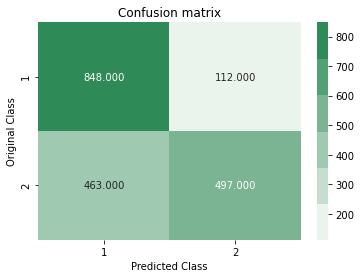

In [31]:
import seaborn as sns
plot_confusion_matrix(y_test, pred_KN)

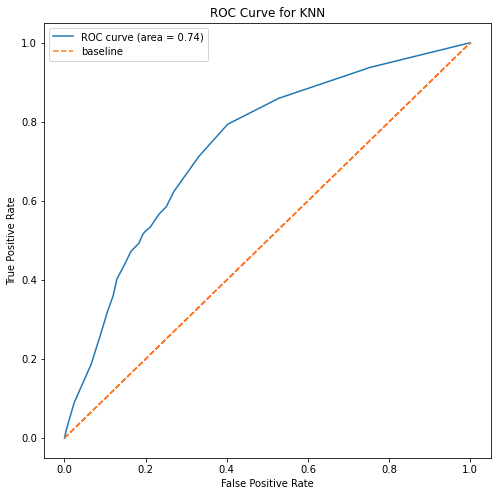

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1],'r--')
fpr, tpr, thresholds = roc_curve(y_test, y_score_3)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label= 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('ROC Curve for KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [18]:
metrics.auc(fpr, tpr)

0.7379096137152779

Text(0, 0.5, 'Probabilities of the positive class')

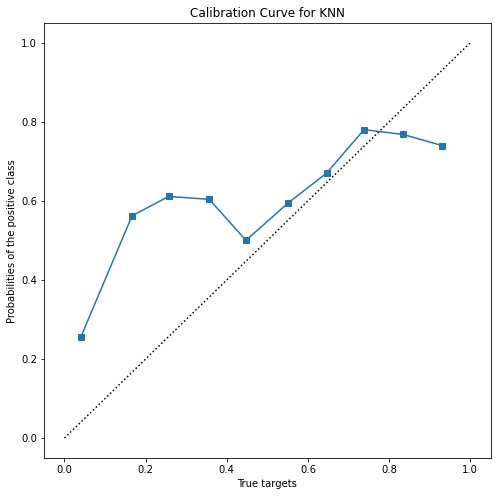

In [17]:
from sklearn.calibration import calibration_curve
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
fraction_of_positives, mean_predicted_value=calibration_curve(y_test,y_score_3,normalize=True,n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives,"s-",
                 label="%s" % 'KNN')
plt.title('Calibration Curve for KNN')
plt.xlabel('True targets')
plt.ylabel('Probabilities of the positive class')

In [ ]:
def model(landmarks):

    features = pd.DataFrame(columns=["EAR","MAR","Circularity","MOE"])

    eye = landmarks[36:68]
    ear = eye_aspect_ratio(eye)
    mar = mouth_aspect_ratio(eye)
    cir = circularity(eye)
    mouth_eye = mouth_over_eye(eye)

    df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)

    df["EAR_N"] = (df["EAR"]-mean["EAR"])/ std["EAR"]
    df["MAR_N"] = (df["MAR"]-mean["MAR"])/ std["MAR"]
    df["Circularity_N"] = (df["Circularity"]-mean["Circularity"])/ std["Circularity"]
    df["MOE_N"] = (df["MOE"]-mean["MOE"])/ std["MOE"]
    
    Result = neigh.predict(df)
    if Result == 1:
        Result_String = "Drowsy"
    else:
        Result_String = "Alert"
    

    return Result_String, df.values

In [ ]:
def calibration():
    data = []
    cap = cv2.VideoCapture(0,cv2.CAP_DSHOW)

    while True:
        # Getting out image by webcam 
        _, image = cap.read()
        # Converting the image to gray scale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Get faces into webcam's image
        rects = detector(image, 0)

        # For each detected face, find the landmark.
        for (i, rect) in enumerate(rects):
            # Make the prediction and transfom it to numpy array
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)
            data.append(shape)
            cv2.putText(image,"Calibrating...", bottomLeftCornerOfText, font, fontScale, fontColor,lineType)

            # Draw on our image, all the finded cordinate points (x,y) 
            for (x, y) in shape:
                cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

        # Show the image
        cv2.imshow("Output", image)

        k = cv2.waitKey(5) & 0xFF
        if k == 27:
            break

    cv2.destroyAllWindows()
    cap.release()
    
    
    features_test = []
    for d in data:
        eye = d[36:68]
        ear = eye_aspect_ratio(eye)
        mar = mouth_aspect_ratio(eye)
        cir = circularity(eye)
        mouth_eye = mouth_over_eye(eye)
        features_test.append([ear, mar, cir, mouth_eye])
    
    features_test = np.array(features_test)
    x = features_test
    y = pd.DataFrame(x,columns=["EAR","MAR","Circularity","MOE"])
    df_means = y.mean(axis=0)
    df_std = y.std(axis=0)
    
    return df_means,df_std

font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,400)
fontScale              = 1
fontColor              = (255,255,255)
lineType               = 2


In [ ]:
def live():
    cap = cv2.VideoCapture(0,cv2.CAP_DSHOW)
    data = []
    result = []
    while True:
        # Getting out image by webcam 
        _, image = cap.read()
        # Converting the image to gray scale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Get faces into webcam's image
        rects = detector(image, 0)

        # For each detected face, find the landmark.
        for (i, rect) in enumerate(rects):
            # Make the prediction and transfom it to numpy array
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)
            Result_String, features = model(shape)
            cv2.putText(image,Result_String, bottomLeftCornerOfText, font, fontScale, fontColor,lineType)
            data.append (features)
            result.append(Result_String)

            # Draw on our image, all the finded cordinate points (x,y) 
            for (x, y) in shape:
                cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

        # Show the image
        cv2.imshow("Output", image)

        k = cv2.waitKey(300) & 0xFF
        if k == 27:
            break

    cv2.destroyAllWindows()
    cap.release()
    
    return data,result

font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,400)
fontScale              = 1
fontColor              = (255,255,255)
lineType               = 2

In [ ]:
#Run Calibration
#mean, std = calibration()


In [ ]:
#Run Demonstration
#features, result = live()